<a href="https://colab.research.google.com/github/GauraoM/PyTorch/blob/main/Training_Deep_Neural_network_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [4]:
# Download the data
dataset = MNIST("/content/", download=True, transform = ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [5]:
# Pick 20%  random for validation set
def split_indices(n, val_pct):
  # Determine the size of validation set'
  n_val = int(val_pct*n)
  # Create random permutation of 0 - n-1
  idxs = np.random.permutation(n)
  # Pick 1st n_val indices for validation_set
  return idxs[n_val:], idxs[:n_val] 

In [6]:
train_indices, val_indices = split_indices(len(dataset), val_pct = 0.2) 

print(len(train_indices)), print(len(val_indices))
print("Sample Val Indices: ",val_indices[:20])

48000
12000
Sample Val Indices:  [55520 44875 47552  5726 34255 20754  8062 12338 33642 14642 31331 31345
 22836 56669 29988 46009 33355 51252 20962 41277]


In [7]:
## Divides the data into the given batch size  

batch_size = 100

# Training Sampler and data loader
train_sampler = SubsetRandomSampler(train_indices) # Helps to randomize the batches, shffle the  data
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)

# Validation Sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size, sampler=valid_sampler)

In [8]:
# Import 
import torch.nn.functional as F
import torch.nn as nn

In [9]:
class MnistModel(nn.Module):
  # Feedforward neural network with one hidden layer
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # Flatten image tensor
    xb = xb.view(xb.size(0),-1)
    # Get intermediate output
    out = self.linear1(xb)
    # Get activation function
    out = F.relu(out)
    # Get prediction using output layer
    out = self.linear2(out)

    return out

In [10]:
# Create model with hidden size 32 
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [11]:
# weight and bias matrix of each layer
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
## take the batch of 100 images and pass them into our model
for images, labels in train_dl:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print("Loss:", loss.item())
  break

print("outputs.shape", outputs.shape)
print("Sample output: \n", outputs[:2].data)

Loss: 2.294252395629883
outputs.shape torch.Size([100, 10])
Sample output: 
 tensor([[ 0.2557,  0.2569,  0.0166,  0.1569,  0.0931, -0.3458,  0.2063,  0.0415,
         -0.1110, -0.1625],
        [ 0.3060,  0.1279, -0.0841,  0.0384,  0.1643, -0.1842,  0.0808,  0.1000,
         -0.0396, -0.1961]])


In [13]:
torch.cuda.is_available()

True

In [14]:
# Helper function if our code uses GPU else CPU
def get_default_device():
  if torch.cuda.is_available():
     return torch.device("cuda")
  else:
     return torch.device("cpu") 

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
## Move the data and model to chosen device
def to_device(data, device):
  """Move tensor to chosen device"""
  if isinstance(data, (list, tuple)): #Checks whether it is list or tuple 
    return [to_device(x, device) for x in data] # move to device
  return data.to(device, non_blocking=True)   

In [17]:
# Move the first batch of data to device
for images, labels in train_dl:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cuda:0


In [19]:
# DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device.
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl =dl
    self.device = device
    
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return (self.dl)      


In [20]:
## Load the data using device loader

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [21]:
for xb, yb in valid_dl:
  print('xb device:',xb.device )
  print('yb:',yb )
  break

xb device: cuda:0
yb: tensor([8, 5, 6, 7, 7, 9, 2, 9, 1, 6, 3, 6, 2, 4, 6, 9, 2, 4, 3, 9, 2, 7, 4, 1,
        2, 4, 7, 7, 6, 1, 5, 4, 1, 4, 6, 8, 8, 4, 2, 0, 9, 3, 9, 1, 3, 1, 1, 2,
        6, 8, 4, 3, 1, 8, 2, 3, 7, 6, 1, 0, 8, 1, 5, 8, 2, 5, 2, 0, 3, 6, 0, 8,
        8, 2, 8, 6, 6, 0, 9, 6, 2, 9, 0, 5, 3, 2, 9, 1, 7, 1, 9, 0, 7, 5, 5, 0,
        0, 3, 3, 3], device='cuda:0')


In [22]:
def loss_batch(model, loss_func, xb, yb, opt= None, metric=None):
  # Generate Predictions
  preds = model(xb)
  # Calculate loss
  loss = loss_func(preds, yb)
  if opt is not None:
    # Compute the gradient
    loss.backward()
    # Update Parameters
    opt.step()
    # Reset gradient
    opt.zero_grad()

  metric_result = None
  if metric is not None:
    # Compute the metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result 

In [23]:
#Evaluate function
def evaluate(model, loss_fn, valid_dl, metric=None):
   with torch.no_grad():
      #pass each batch through the model
      results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]

      # Seperate losses, count, metrics
      losses, nums, metrics = zip(*results)
      # Toatl size of the dataset
      total = np.sum(nums)
      # Average loss across batches
      avg_loss = np.sum(np.multiply(losses, nums)) / total
      avg_metric = None

      if metric is not None:
          # Average of metric across batches
          avg_metric = np.sum(np.multiply(metrics, nums)) / total 

   return avg_loss, total, avg_metric 


In [24]:
# Fitting the model
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn=None):

  losses, metrics =[], []
  # Instantiate the optimizer
  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr=lr)

  for epoch in range(epochs):
    #Training
    for xb, yb in train_dl:
      loss_batch(model, loss_fn, xb ,yb, opt)

    # Evaluation
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    # Record the loss and metric
    losses.append(val_loss)
    metrics.append(val_metric)

    #print progress
    if metric is None:
        print('Epoch[{}/{}], Loss:{:.4f}'.format(epoch+1, epochs, val_loss))
    else:
        print('Epoch[{}/{}], Loss:{:.4f}, {}:{:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__,val_metric)) 

  return losses, metrics

In [25]:
# Compares the ouput and label gives how accurate our model
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

In [27]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [28]:
# Let's see how the model performs on the validation set with the initial set of weights and biases.

val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.2934, Accuracy: 0.0938


#### Train the model

In [29]:
# Train the model for 5 epochs
losses1, metrics1 = fit(5,0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch[1/5], Loss:0.2186, accuracy:0.9368
Epoch[2/5], Loss:0.1659, accuracy:0.9515
Epoch[3/5], Loss:0.1514, accuracy:0.9555
Epoch[4/5], Loss:0.1348, accuracy:0.9608
Epoch[5/5], Loss:0.1346, accuracy:0.9611


In [30]:
losses2, metrics2 = fit(5,0.1, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch[1/5], Loss:0.1171, accuracy:0.9658
Epoch[2/5], Loss:0.1168, accuracy:0.9653
Epoch[3/5], Loss:0.1153, accuracy:0.9664
Epoch[4/5], Loss:0.1169, accuracy:0.9648
Epoch[5/5], Loss:0.1159, accuracy:0.9664


Text(0.5, 1.0, 'Accuracy vs No.of epochs')

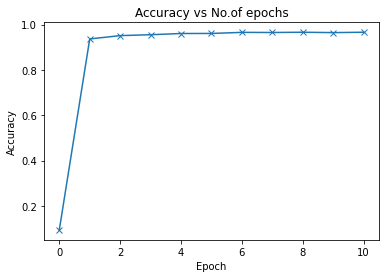

In [31]:
import matplotlib.pyplot as plt

accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies,'-x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs No.of epochs")